Keys in the npz file: KeysView(NpzFile 'sstu_1993_2022.npz' with keys: lon, lat, sstu, sstc, coast...)
Keys in the npz file: KeysView(NpzFile 'fesom_core2_fjra_ekman_d_1993_2022.npz' with keys: windspeed, etransport, epumping)
Keys in the npz file: KeysView(NpzFile 'fesom_core2_fjra_w_mld1_d_1993_2022.npz' with keys: w_mld, lono, lato)
Keys in the npz file: KeysView(NpzFile 'fesom_core2_fjra_wg_mld1_d_1993_2022.npz' with keys: wgc)


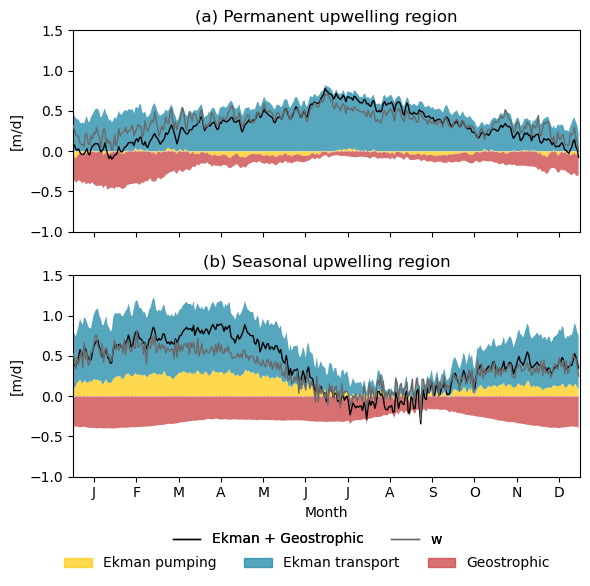

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# load data
npz = np.load('sstu_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
sst = npz["sstc"]
coast = npz["coast"]
time = npz["time"]

nn=-8

npz = np.load('fesom_core2_fjra_ekman_d_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
last_slice = npz["etransport"][:,:,nn:][:, :, 0] * 86400              # (366, 100)
etransport = np.broadcast_to(last_slice[..., None],           # (366, 100, 1)
                             npz["etransport"][:,:,nn:].shape)
epumping = npz["epumping"][:,:,nn:]*86400

# npz = np.load('fesom_core2_fjra_d_1993_2022.npz', allow_pickle=True)
npz = np.load('fesom_core2_fjra_w_mld1_d_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
lato = npz["lato"]
ww = npz['w_mld'][:,:,nn:]*86400

npz = np.load('fesom_core2_fjra_wg_mld1_d_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
# wg = npz['wgc']*86400
last_slice = npz["wgc"][:,:,nn:][:, :, 0] * 86400              # (366, 100)
wg = np.broadcast_to(last_slice[..., None],           # (366, 100, 1)
                             npz["wgc"][:,:,nn:].shape)

lat = np.mean(lato, axis=1)  

region_names = {
    (21, 30): "Permanent upwelling region",
    (12, 19): "Seasonal upwelling region",
}
# Latitude bands
latitude_bands = [(21, 30), (12, 19)]

def plot_budget_results(lat, budget_terms, latitude_bands):
    """Plot the mean evolution of budget terms for specified latitude bands in subplots."""
    labels = ["Ekman + Geostrophic", "w","Ekman pumping", "Ekman transport", "Geostrophic"]
    colors = {
        "Ekman + Geostrophic": "k",
        "w": "dimgrey",
        "Geostrophic": "#ca4042",
        "Ekman pumping": "#fecc12",#'#5aae25',
        "Ekman transport": "#1e88a8",

    }
    panel_labels = ["(a)", "(b)"]
    alpha=.75

    fig, axes = plt.subplots(len(latitude_bands), 1, figsize=(6,6), sharex=True)

    for ax, (lat_min, lat_max), panel in zip(axes, latitude_bands, panel_labels):
        mask = (lat >= lat_min) & (lat <= lat_max)
        days = np.arange(budget_terms[0].shape[0])

        mean_terms = {label: np.nanmean(term[:, mask, :], axis=(1, 2))
                      for term, label in zip(budget_terms, labels)}

        fill_labels = [l for l in labels if l not in ["Ekman + Geostrophic", "w"]]

        cumulative_pos = np.zeros_like(days, dtype=float)
        cumulative_neg = np.zeros_like(days, dtype=float)

        for l in fill_labels:
            vals = mean_terms[l]
            color = colors[l]
            pos_vals = np.where(vals > 0, vals, 0)
            neg_vals = np.where(vals < 0, vals, 0)

            ax.fill_between(
                days, cumulative_pos, cumulative_pos + pos_vals,
                color=color, alpha=alpha, edgecolor='none', linewidth=0, zorder=1
            )
            cumulative_pos += pos_vals

            ax.fill_between(
                days, cumulative_neg, cumulative_neg + neg_vals,
                color=color, alpha=alpha, edgecolor='none', linewidth=0, zorder=1
            )
            cumulative_neg += neg_vals

        for l in ["Ekman + Geostrophic", "w"]:
            ax.plot(days, mean_terms[l], color=colors[l], linewidth=1, zorder=5)

        ax.axhline(0, linestyle='dashed', color='gainsboro',linewidth=.5, zorder=2)
        ax.set_ylim(-1, 1.5)
        region_title = region_names[(lat_min, lat_max)]
        ax.set_title(f"{panel} {region_title}")
        ax.set_ylabel("[m/d]")

    month_labels = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]

    days_total = budget_terms[0].shape[0]
    # 12 ticks at the middle of each month span (roughly every 1/12 of total days)
    month_days = np.linspace(0, days_total, 13)[:-1] + days_total / 24  # shift half a month

    axes[-1].set_xticks(month_days)
    axes[-1].set_xticklabels(month_labels)
    axes[-1].set_xlim(0, days_total)  # ensures no whitespace on both ends
    axes[-1].set_xlabel("Month")

    # ✅ 手动构造图例（同时包含填色项和线条项）
    fill_patches = [mpatches.Patch(color=colors[l], alpha=alpha, label=l) for l in fill_labels]
    line_handles = [mlines.Line2D([], [], color=colors[l], linewidth=1, label=l)
                    for l in ["Ekman + Geostrophic", "w"]]

    # 将图例放在下方：线条一行，填色一行
    legend1 = fig.legend(line_handles, [h.get_label() for h in line_handles],
                         loc="lower center", bbox_to_anchor=(0.52, 0.06),
                         ncol=len(line_handles), frameon=False)

    legend2 = fig.legend(fill_patches, [h.get_label() for h in fill_patches],
                         loc="lower center", bbox_to_anchor=(0.52, 0.02),
                         ncol=len(fill_patches), frameon=False)

    fig.add_artist(legend1)  # 确保 legend1 不被 legend2 覆盖

    plt.tight_layout(rect=[0, 0.1, 1, 1])  # 为下方图例留空间


vetical_velocity=[epumping+etransport+wg,ww,epumping,etransport,wg]
plot_budget_results(lat, vetical_velocity, latitude_bands)
plt.savefig("fig6.png", dpi=300, bbox_inches='tight')                    
plt.show()
